<div style="text-align:center">
    <h1>
        Off-policy Monte Carlo Control
    </h1>
</div>
<br>

In this notebook we are going to implement the other of the two major strategies that exist when learning a policy by interacting with the environment, called off-policy learning. We will use two policies: 
    
- An exploratory policy called b.
    
- A target policy that will learn from the experience collected by b, called $\pi$

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 4 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from envs import Maze
from utils import plot_policy, plot_action_values, test_agent

## Initialize the environment

In [2]:
env = Maze()

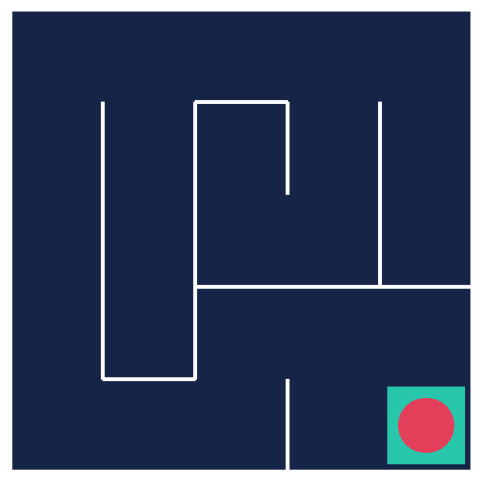

In [3]:
frame = env.render(mode='rgb_array')
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(frame)

In [4]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


## Define value table $Q(s, a)$

#### Create the $Q(s, a)$ table

In [5]:
action_values = np.full((5,5,4), -100.0) 
action_values[(4,4)] = 0.0

# action vals should be initialized with a very small value than the goal state
# for smaller values close to 0.0, the policy still doensn't converge (for any value of eps) ==>
# because, even after following the learning process, the entries of the q-value table don't
# turn to their optimal value.
# for eg, the opti. q val for cells (0,0) and (1,0) are smaller than -9 (-9.76). So an initial value of say -7.0
# will never make state (0,0) reach its optimal val.
# TODO: change initial values to zero : if this is done, then all states
# have the value as the goal state and the target policy fails
# for values larger than goal state, the problem is invalid, as the agent only reaches the goal when
# policy maximizes the reward

#### Plot $Q(s, a)$

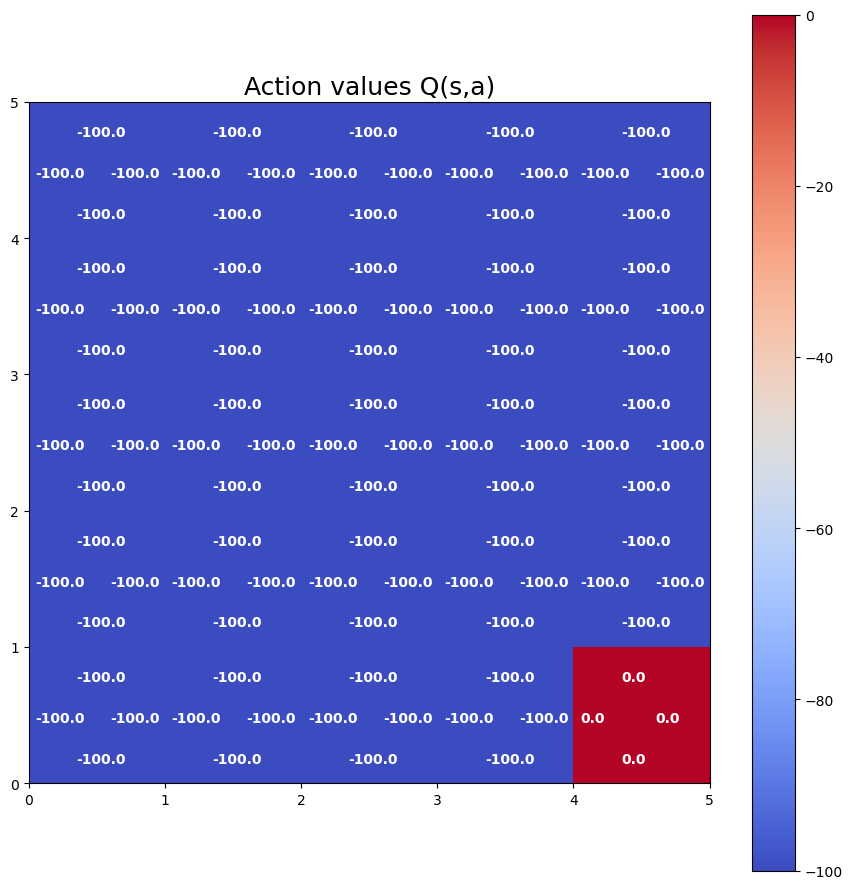

In [6]:
plot_action_values(action_values)

## Define the target policy $\pi(s)$

#### Create the policy $\pi(s)$

In [7]:
def target_policy(state):
    # policy takes as argument a state and it returns the action with the highest q-value for that state.
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av == av.max()))

#### Test the policy with state (0, 0)

In [8]:
action = target_policy((0,0))
print(f"Action taken in state (0,0) is : {action}")

Action taken in state (0,0) is : 1


#### Plot the policy

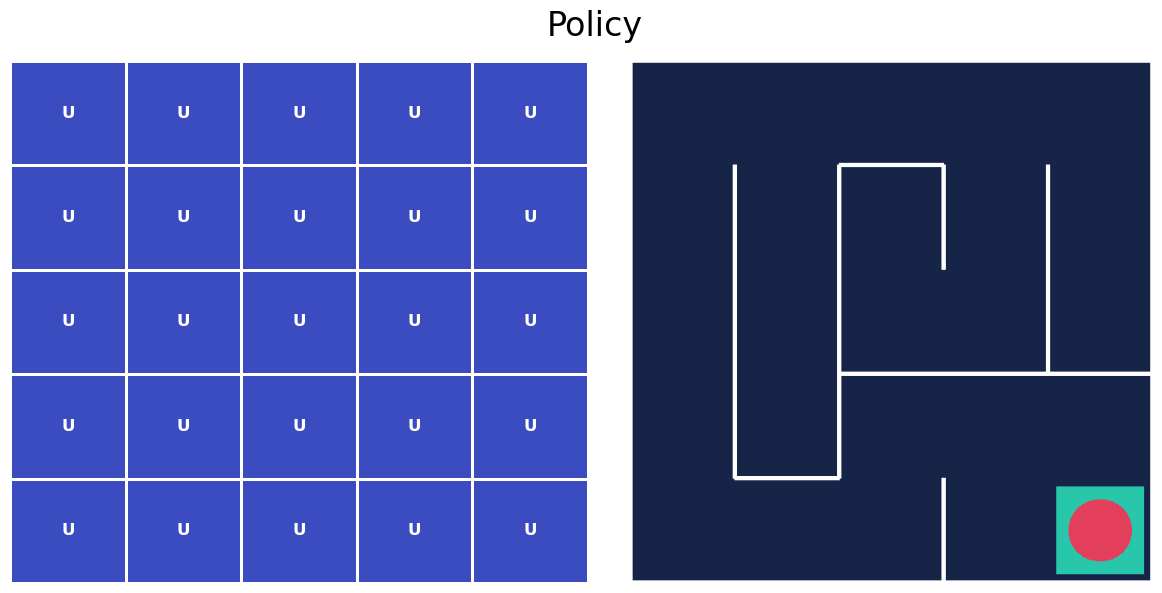

In [9]:
plot_policy(action_values, frame)

## Define the exploratory policy $b(s)$

#### Create the policy $b(s)$

In [10]:
def exploratory_policy(state, epsilon=0.2):
    # epsilon-greedy policy
    if np.random.random() < epsilon:
        return np.random.choice(4) #select one of the available actions randomly
    else:
        av = action_values[state] 
        # av will return is the action with the highest Q value.
        return np.random.choice(np.flatnonzero(av == av.max()))

#### Test the policy with state (0, 0)

In [11]:
action = exploratory_policy((0,0))
print(f"Action taken in state (0,0) is : {action}")

Action taken in state (0,0) is : 0


## Implement the algorithm

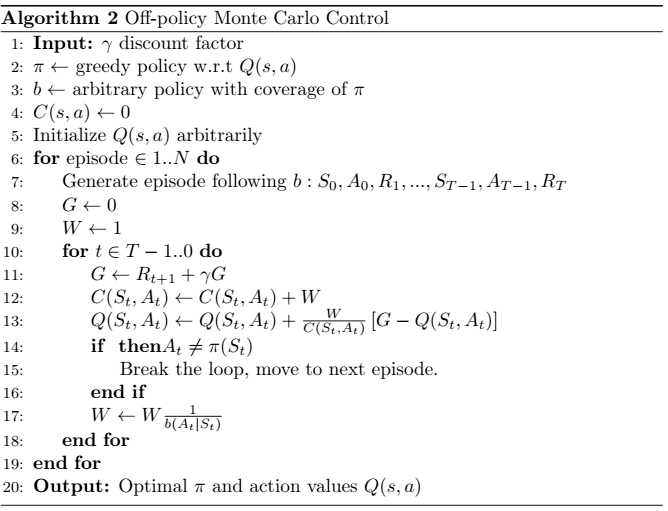

</br>



<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>

In [12]:
def off_policy_mc_control(action_values, target_policy, explanatory_policy, episodes, gamma=0.99, epsilon=0.2):
    csa = np.zeros((5,5,4))
    
    for episode in range(1, episodes+1):
        G = 0
        W = 1
        state = env.reset()
        done =  False
        transitions = []
        
        while not done:
            action = exploratory_policy(state) # we use exp policy to gain experience
            next_state, reward, done, _ = env.step(action)
            transitions.append([state, action, reward])
            state = next_state
            
        for state_t, action_t, reward_t in reversed(transitions):
            G = reward_t + gamma * G
            csa[state_t][action_t] += W
            qsa = action_values[state_t][action_t]
            action_values[state_t][action_t] += (W / csa[state_t][action_t])*(G - qsa)
            
            # with probability epsilon, exp policy picks a random action and since the target policy is 
            # not eps-greedy, the picked action won't exist with the target policy, so break the loop.
            if action_t != target_policy(state_t):
                break
            
            # line 17, denominator = probability that the explanatory policy has to pick the action
            # i.e.,the action with the highest q-value. This is the else loop of eps-greedy policy
            # and the prob with which this action gets picked is 1 - epsilon + epsilon/4
            # Lecture 41 0:15
            W *= 1. / 1 - epsilon + epsilon/4
        

In [13]:
off_policy_mc_control(action_values, target_policy, exploratory_policy, episodes=1000, epsilon=0.3)

## Show results

#### Show resulting value table $Q(s, a)$

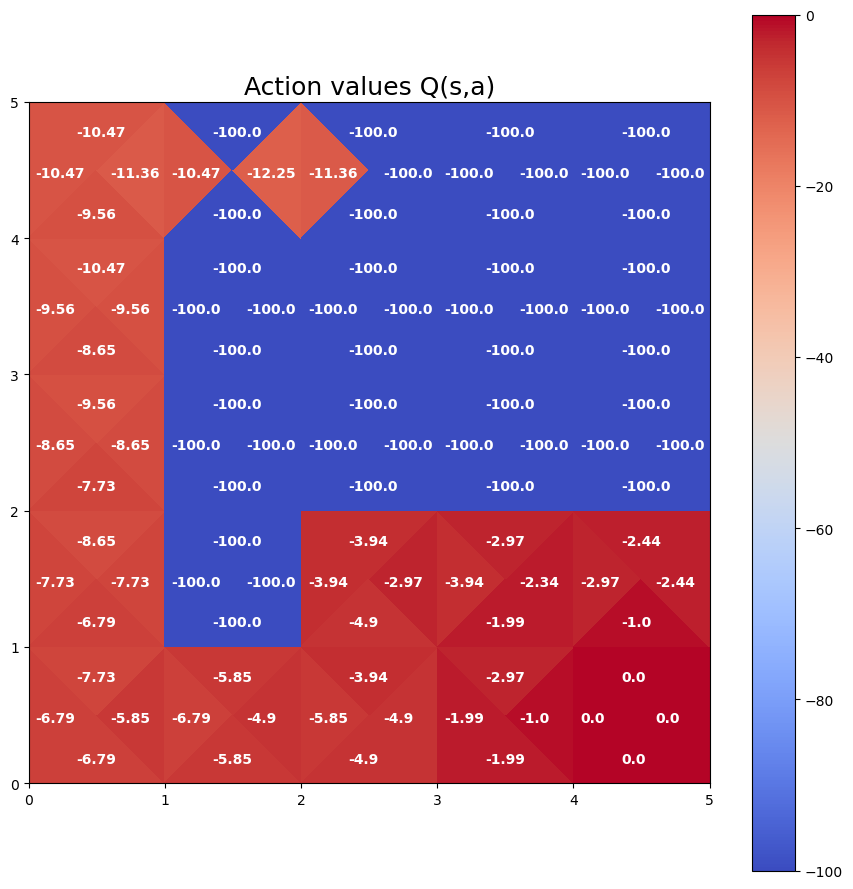

In [14]:
plot_action_values(action_values)

#### Show resulting policy $\pi(\cdot|s)$

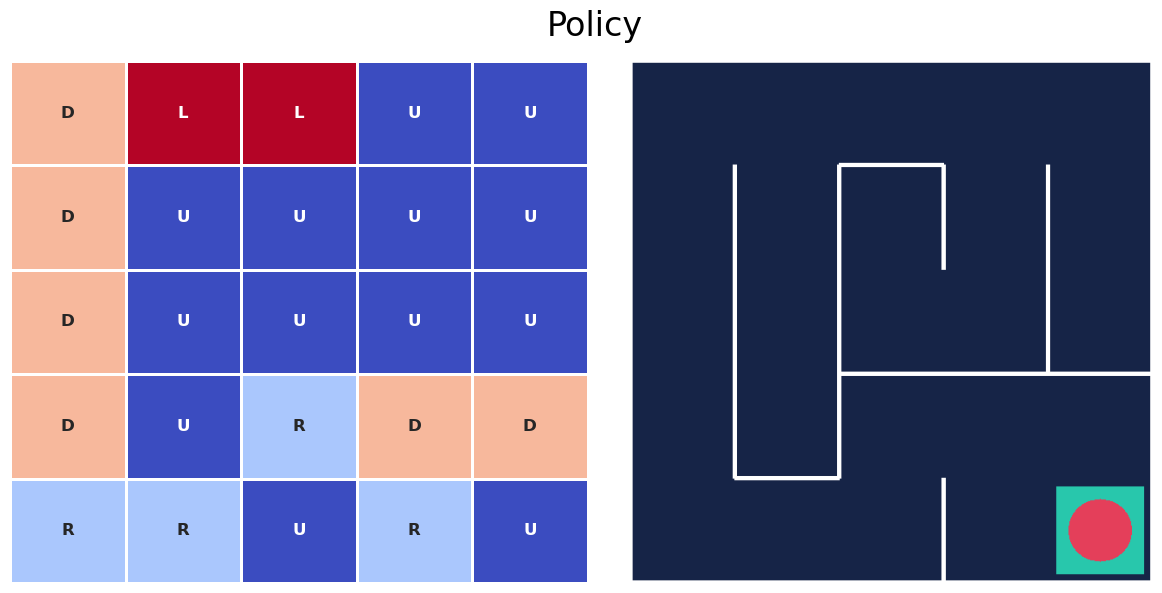

In [15]:
plot_policy(action_values, frame)

#### Test the resulting agent

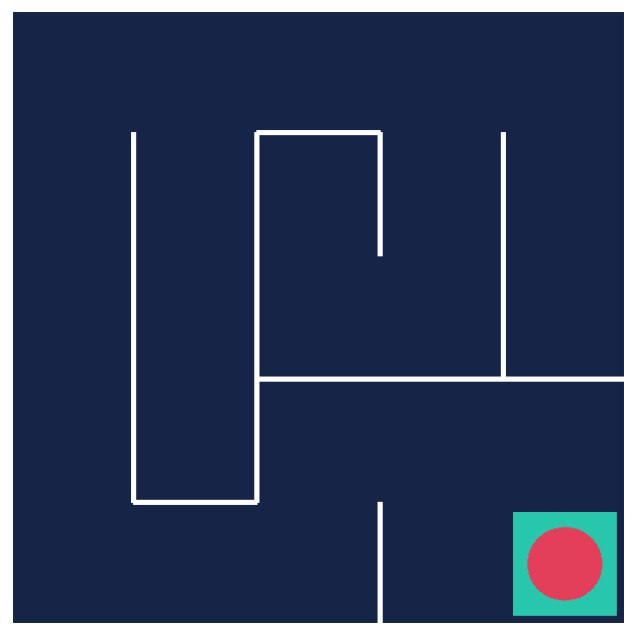

In [16]:
test_agent(env, target_policy)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch. 5: Monte Carlo methods](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)